# Regressão Linear Múltipla

O objetivo deste notebook é explorar a regressão múltipla e engenharia de atributos com as funções da API Scikit-learn.

Neste notebook você irá manipular dados de transações imobiliárias de King County para prever preços usando regressão múltipla. Desta forma, você poderá:
* Usar Pandas DataFrames para realizar algumas atividades de engenharia de atributos
* Usar funções do Scikit-learn para computar os coeficientes de regressão (pesos/parâmetros)
* Dados os coeficientes de regressão, os preditores e a saída (preços), criar uma função para computar erro utilizando a técnica de mínimos quadrados (Residual Sum of Squares).
* Visualizar os coeficientes e interpretar seus significados

## Importação das bibliotecas

Importação de bibliotecas necessárias para a execução dos comandos:
* Pandas: para manipulação dos dados
* Numpy: para compatibilizar o uso de dados por algumas funções
* Datetime: para formatar um dos atributos da base de dados
* Sklearn: para uso comparativo de funções de regressão linear

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std

# Leitura dos dados

O dataset contém dados de transações imobiliárias de King County, região aonde está a cidade de Seattle, USA.

## Dicionário de variáveis

![dicionario](https://miro.medium.com/v2/resize:fit:640/format:webp/1*aBClHGo8tIhVFrnpKN3-dw.jpeg)

In [3]:
df = pd.read_csv("kc_house_data.csv")
sales = df.copy()

## Análise Exploratória dos Dados - Exploratory Data Analysis (EDA) e Pré-processamento

Antes de criarmos o modelo de regressão, vamos primeiro explorar os dados:
* Por meio do uso de algumas funções nativas do Pandas (**.info()** e **.describe()**) é possível extrair uma visão geral dos atributos do dataset;
    * A função *info()* retorna informações específicas sobre os tipos de dados de cada um dos atributos, além de informações sobre uso de memória pela estrutura do mesmo;
    * A função *describe()* retorna informações estatísticas em geral referentes aos dados de cada atributo.

In [4]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
sales.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### Eliminação manual de atributos que direta ou indiretamente não contribuem para o modelo

Remoção dos atributos *'id' e 'date'*

In [7]:
sales.drop(['id'],axis=1,inplace=True)
sales.drop(['date'],axis=1,inplace=True)

#### Verificação de quantos objetos contém valor igual a ZERO para cada um dos parâmetros
Esta análise indica, de imediato, uma "luz vermelha" que devemos considerar quanto aos parâmetros **waterfront**, **view**, **yr_renovated** e **sqft_basement**. 
* Quase todos os parâmetros contém aproximadamente **90%** ou mais de seus dados com valor igual a zero.

In [8]:
(sales[sales[sales.columns] == 0]).count()

price                0
bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21450
view             19489
condition            0
grade                0
sqft_above           0
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

#### Verificação de quantos valores únicos cada atributo possui
Esta verificação foi realizada para se ter uma visão geral dos intervalos de valores que cada atributo apresenta.

In [9]:
sales.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

O comando abaixo identifica os atributos com menor quantidade de valores únicos (<= 20):

In [10]:
sales.nunique()<=20

price            False
bedrooms          True
bathrooms        False
sqft_living      False
sqft_lot         False
floors            True
waterfront        True
view              True
condition         True
grade             True
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [11]:
colunas = sales.columns.values
colunas

array(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

Separando as variáveis:

* Quantitativas:

'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15'

* Qualitativas:

'waterfront', 'view', 'condition', 'grade'

* Localização:

'zipcode', 'lat', 'long'

In [12]:
colunas_quant = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

colunas_quali = ['waterfront', 'view', 'condition', 'grade']

colunas_loc = ['zipcode', 'lat', 'long']

key_colunas = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'waterfront', 'view', 'condition', 'grade', 'zipcode', 'lat', 'long']

Text(0.5, 0.92, 'Histograma das variáveis')

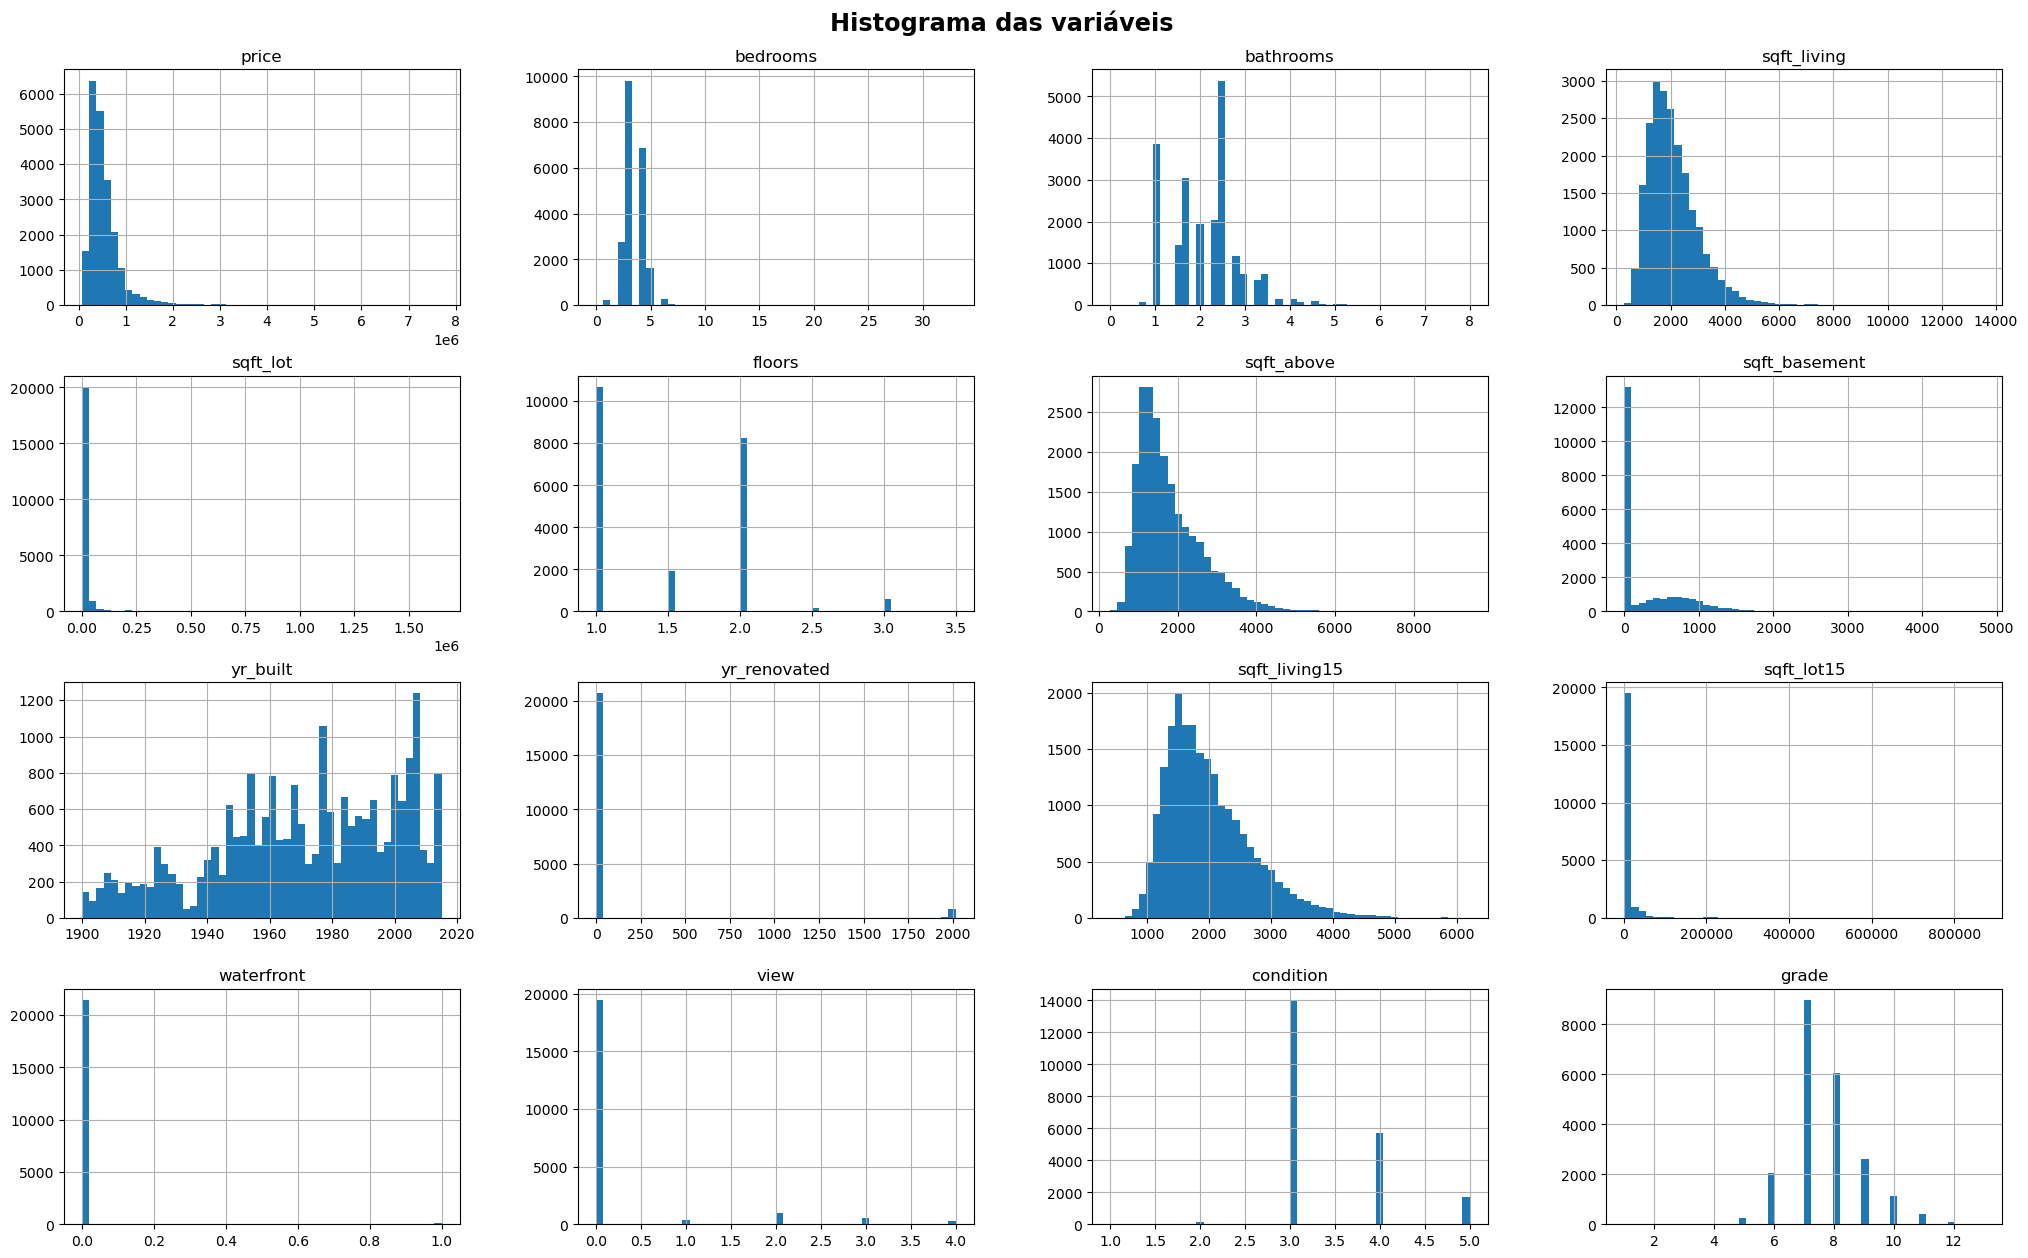

In [13]:
sales[colunas_quant+colunas_quali].hist(bins=50, figsize=(25,15))
plt.suptitle('Histograma das variáveis', size='xx-large', weight='bold',y = .92)

Text(0.5, 0.92, 'Distribuição das variáveis')

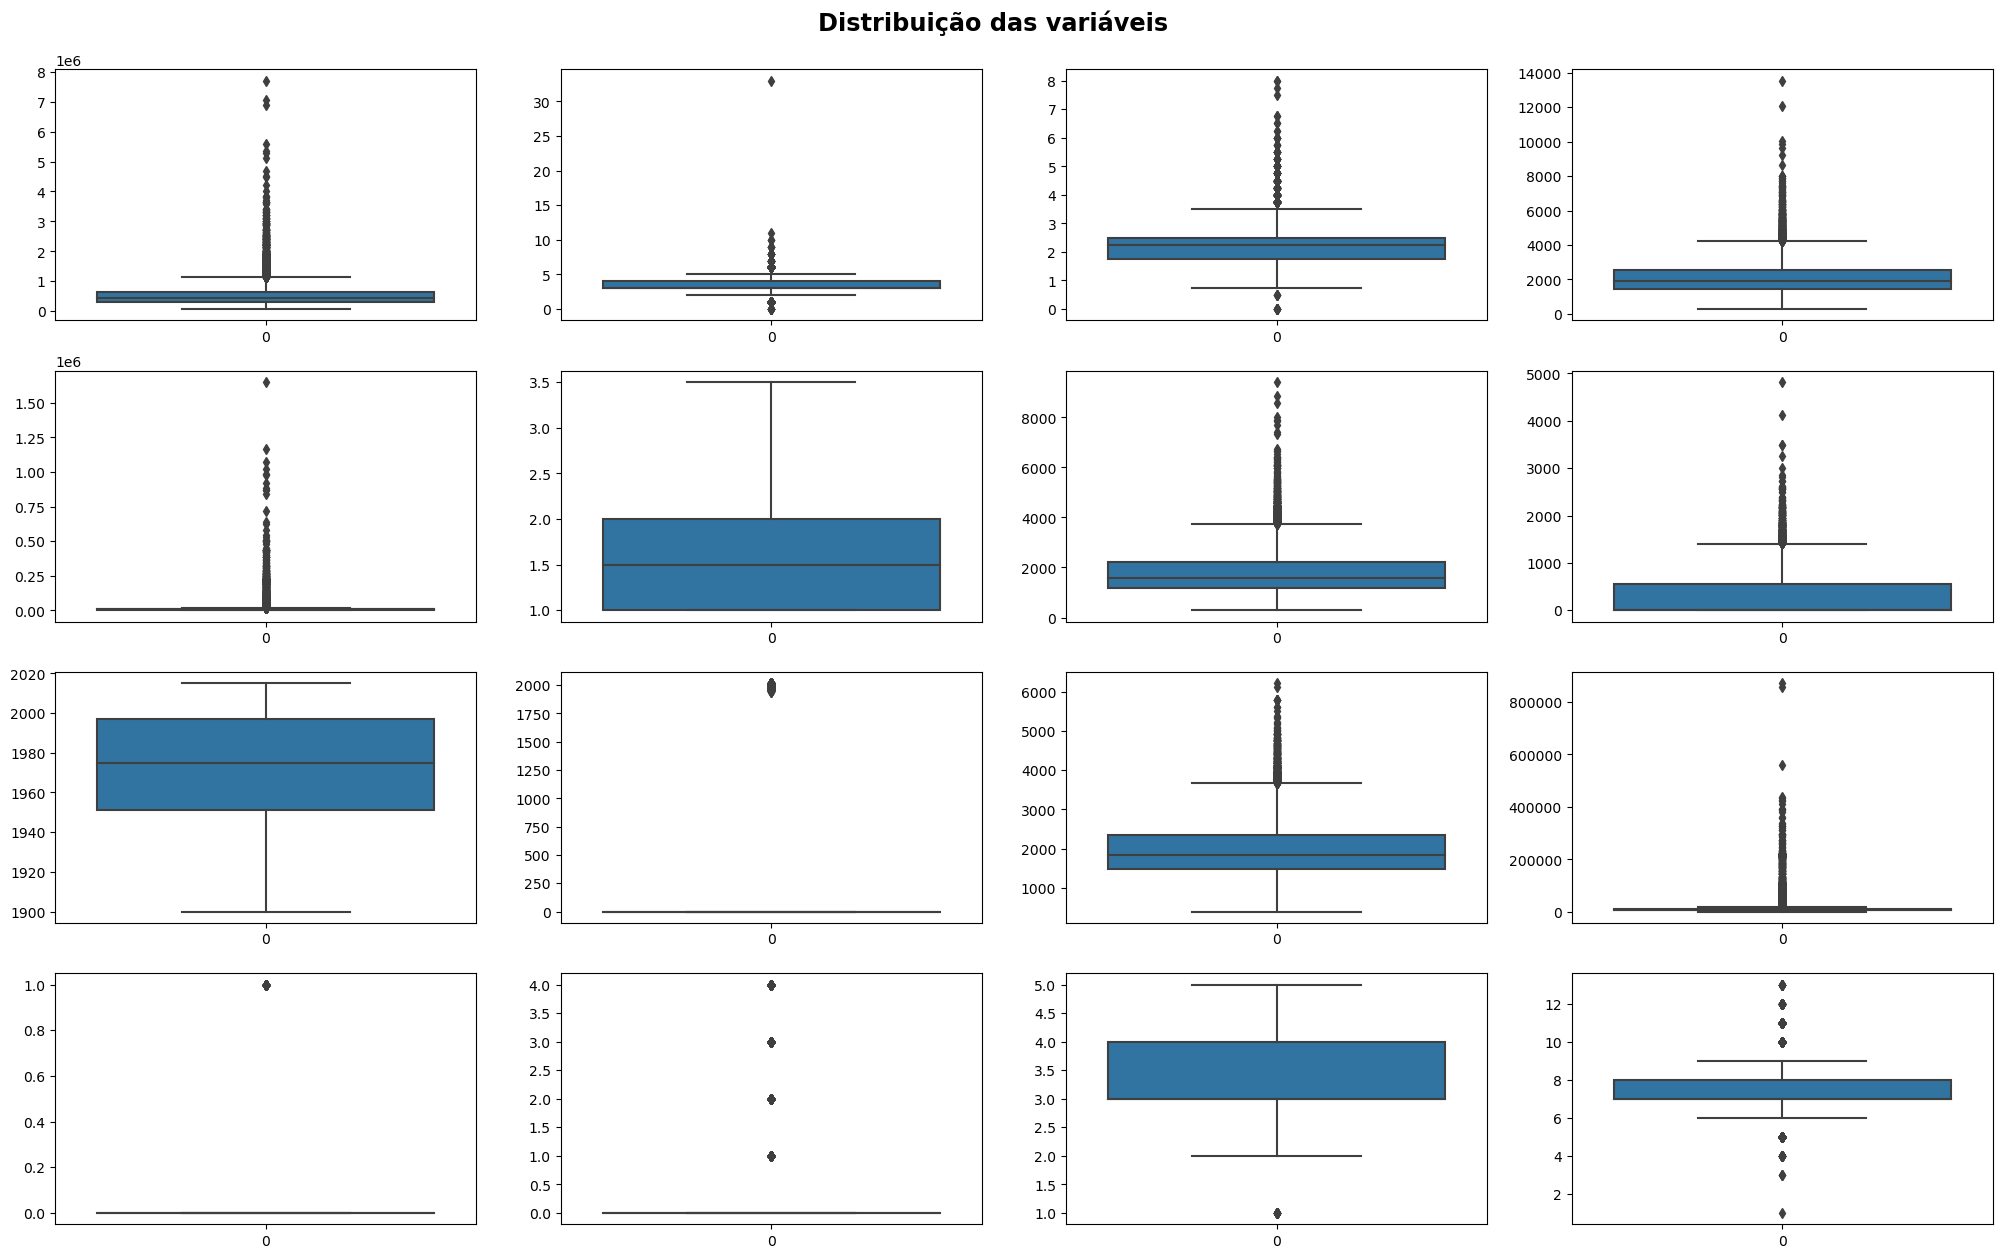

In [14]:
fig, ax = plt.subplots(4, 4, figsize=(25,15))
i=0
for col in colunas_quant+colunas_quali:
    sns.boxplot(sales[col], ax=ax[int(i/4),i%4])
    i+=1

plt.suptitle('Distribuição das variáveis', size='xx-large', weight='bold',y=0.92)

c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

Text(0.5, 0.92, 'Relação das variáveis com o preço')

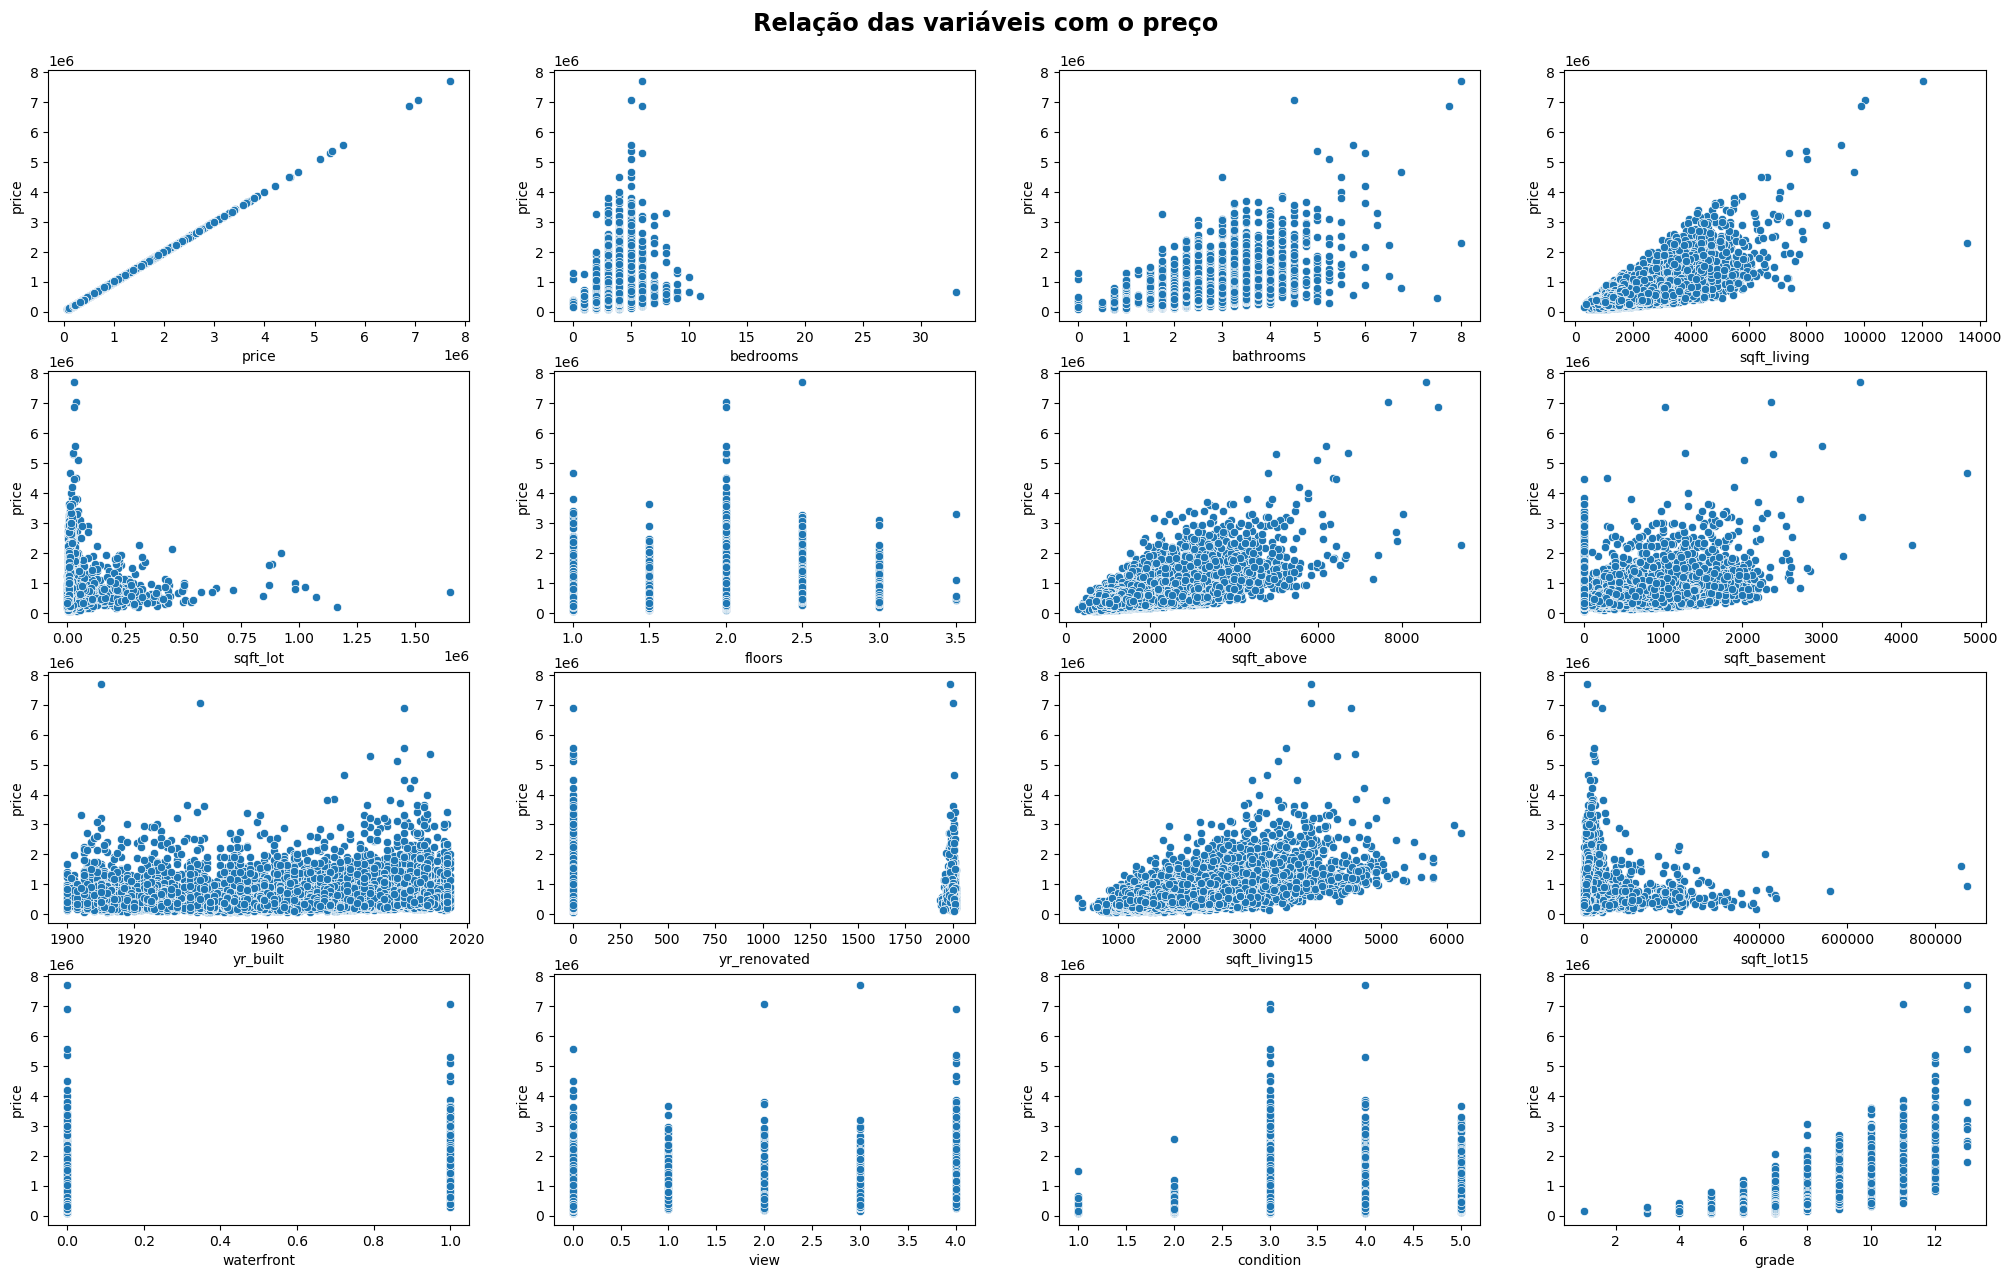

In [15]:
fig, ax = plt.subplots(4, 4, figsize=(25,15))
i=0
for col in colunas_quant+colunas_quali:
    sns.scatterplot(sales, x=sales[col], y=sales['price'], ax=ax[int(i/4),i%4])
    i+=1

plt.suptitle('Relação das variáveis com o preço', size='xx-large', weight='bold',y=0.92)

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='bedrooms', ylabel='price'>,
        <Axes: xlabel='bathrooms', ylabel='price'>,
        <Axes: xlabel='sqft_living', ylabel='price'>,
        <Axes: xlabel='sqft_lot', ylabel='price'>,
        <Axes: xlabel='floors', ylabel='price'>,
        <Axes: xlabel='sqft_above', ylabel='price'>,
        <Axes: xlabel='sqft_basement', ylabel='price'>,
        <Axes: xlabel='yr_built', ylabel='price'>,
        <Axes: xlabel='yr_renovated', ylabel='price'>,
        <Axes: xlabel='sqft_living15', ylabel='price'>,
        <Axes: xlabel='sqft_lot15', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='bedrooms'>,
        <Axes: xlabel='bedrooms', ylabel='bedrooms'>,
        <Axes: xlabel='bathrooms', ylabel='bedrooms'>,
        <Axes: xlabel='sqft_living', ylabel='bedrooms'>,
        <Axes: xlabel='sqft_lot', ylabel='bedrooms'>,
        <Axes: xlabel='floors', ylabel='bedrooms'>,
        <Axes: xlabel='sqft_above', ylabel='bed

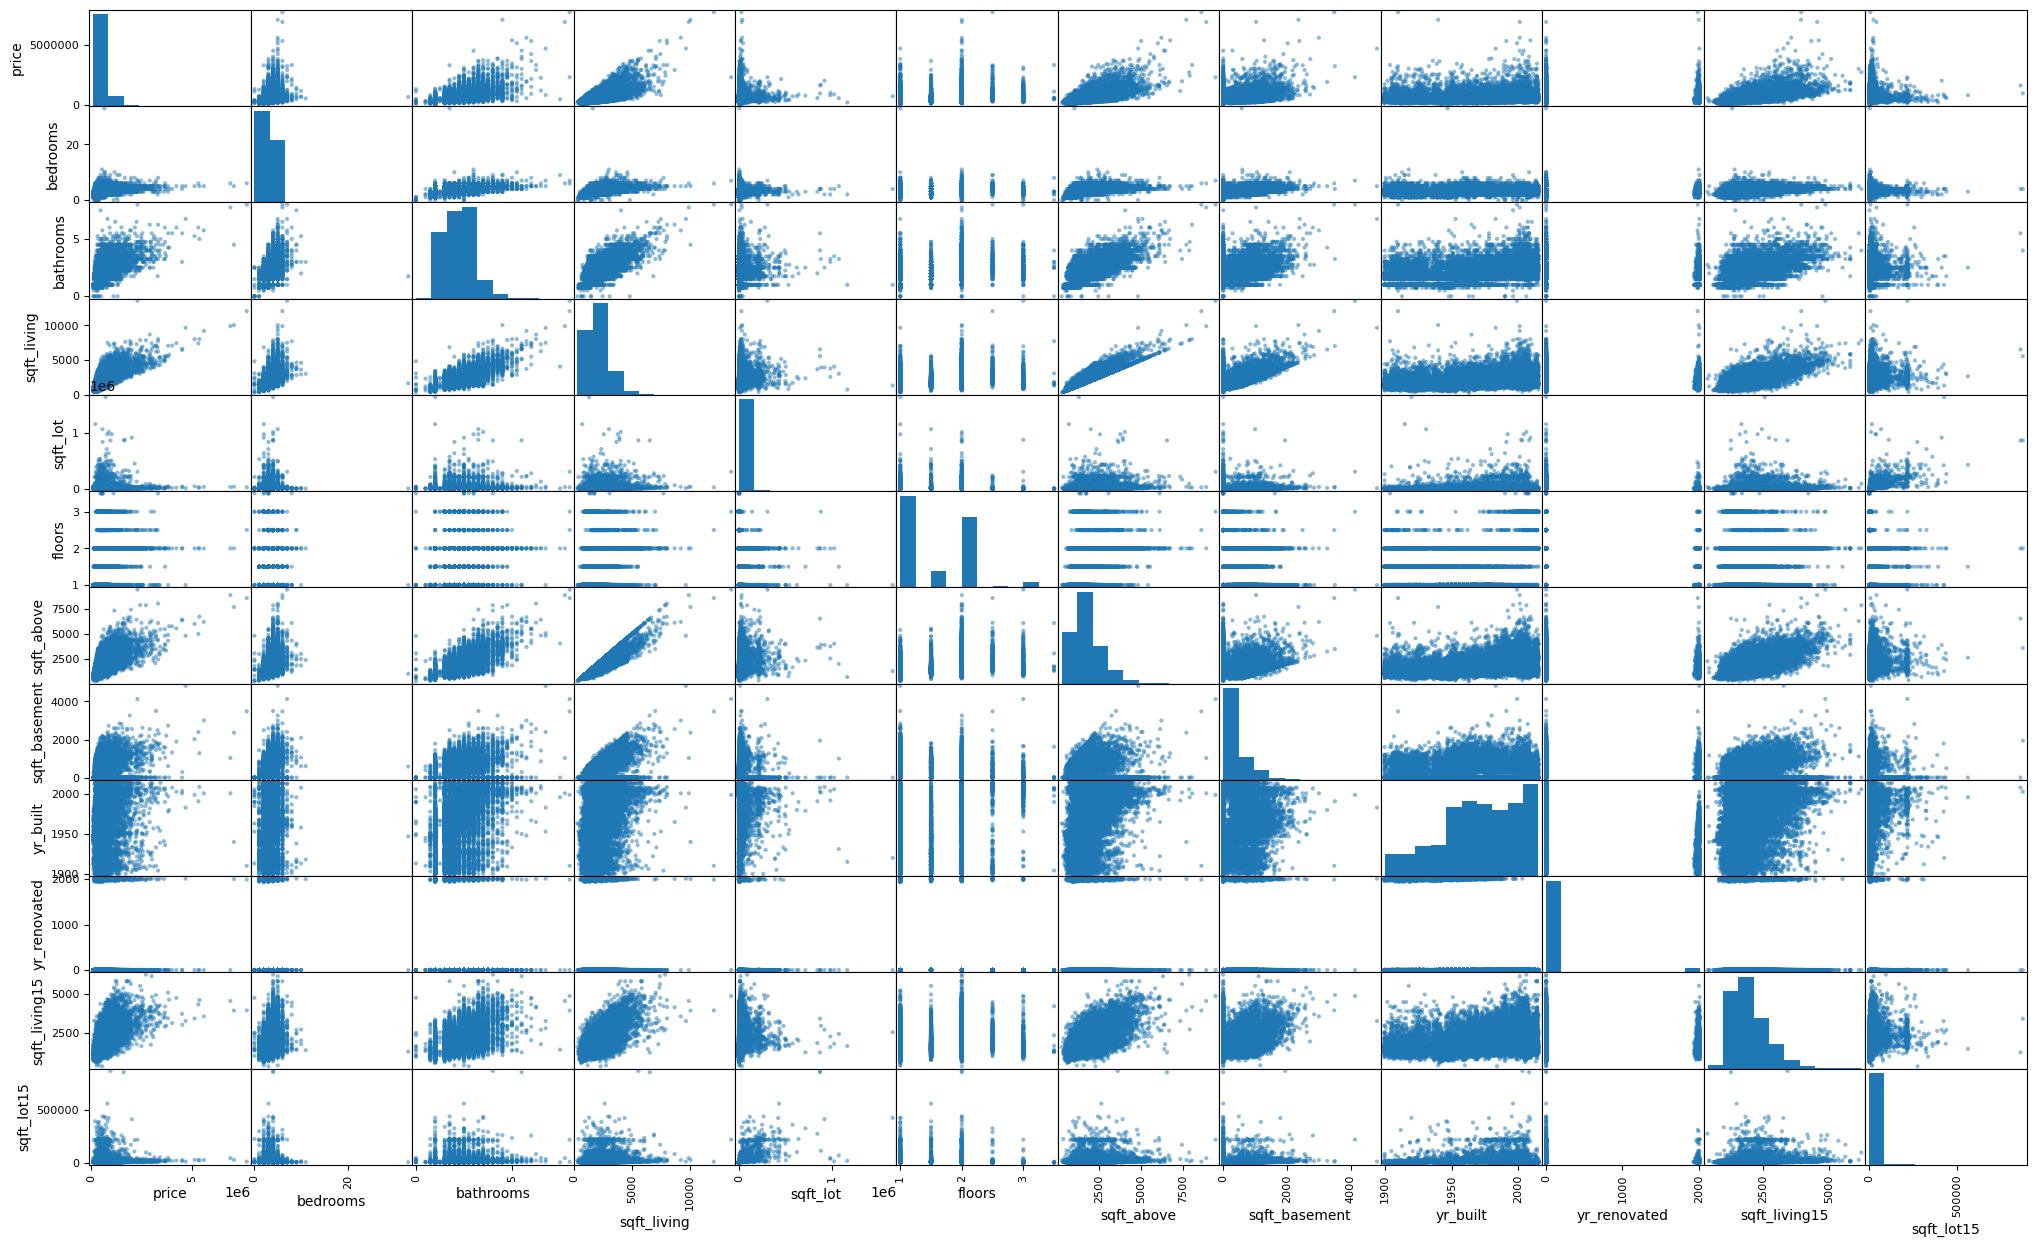

In [16]:
pd.plotting.scatter_matrix(sales[colunas_quant], figsize=(25, 15))


<Axes: >

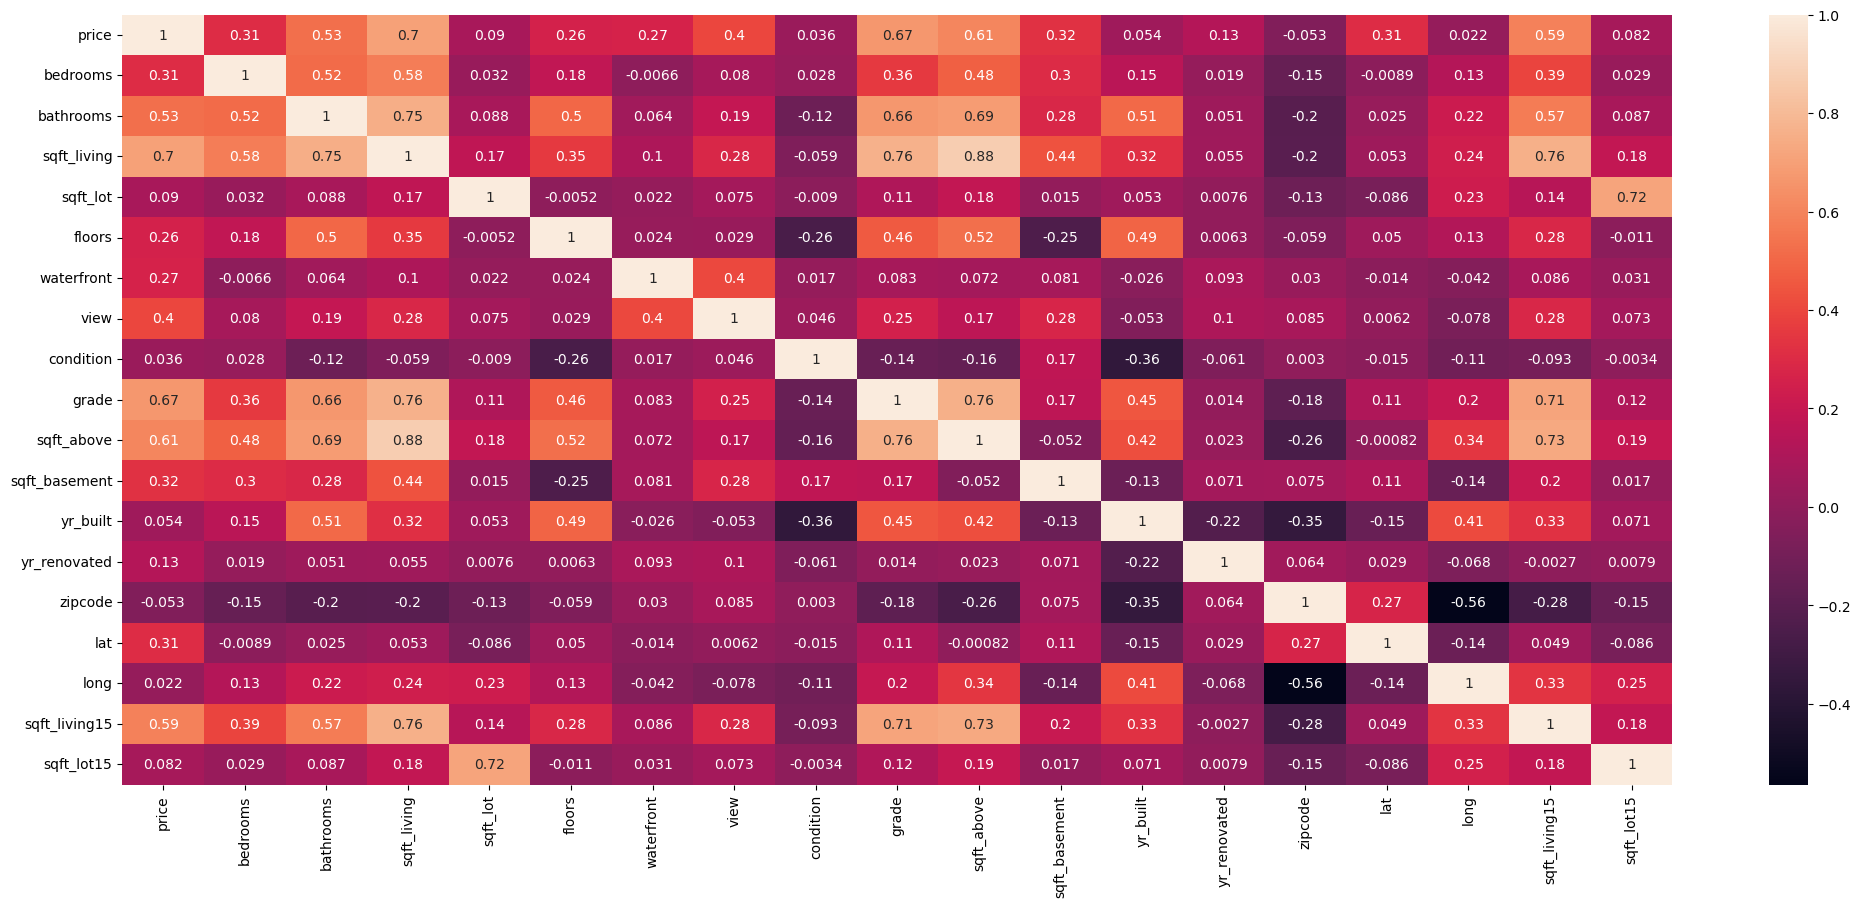

In [17]:
plt.figure(figsize=(25,10))
sns.heatmap(sales.corr(), annot=True)


In [18]:
abs(sales.corr())>.6

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
sqft_living,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False


Text(0.5, 0.92, 'Relação das variáveis com o preço e linha de regressão')

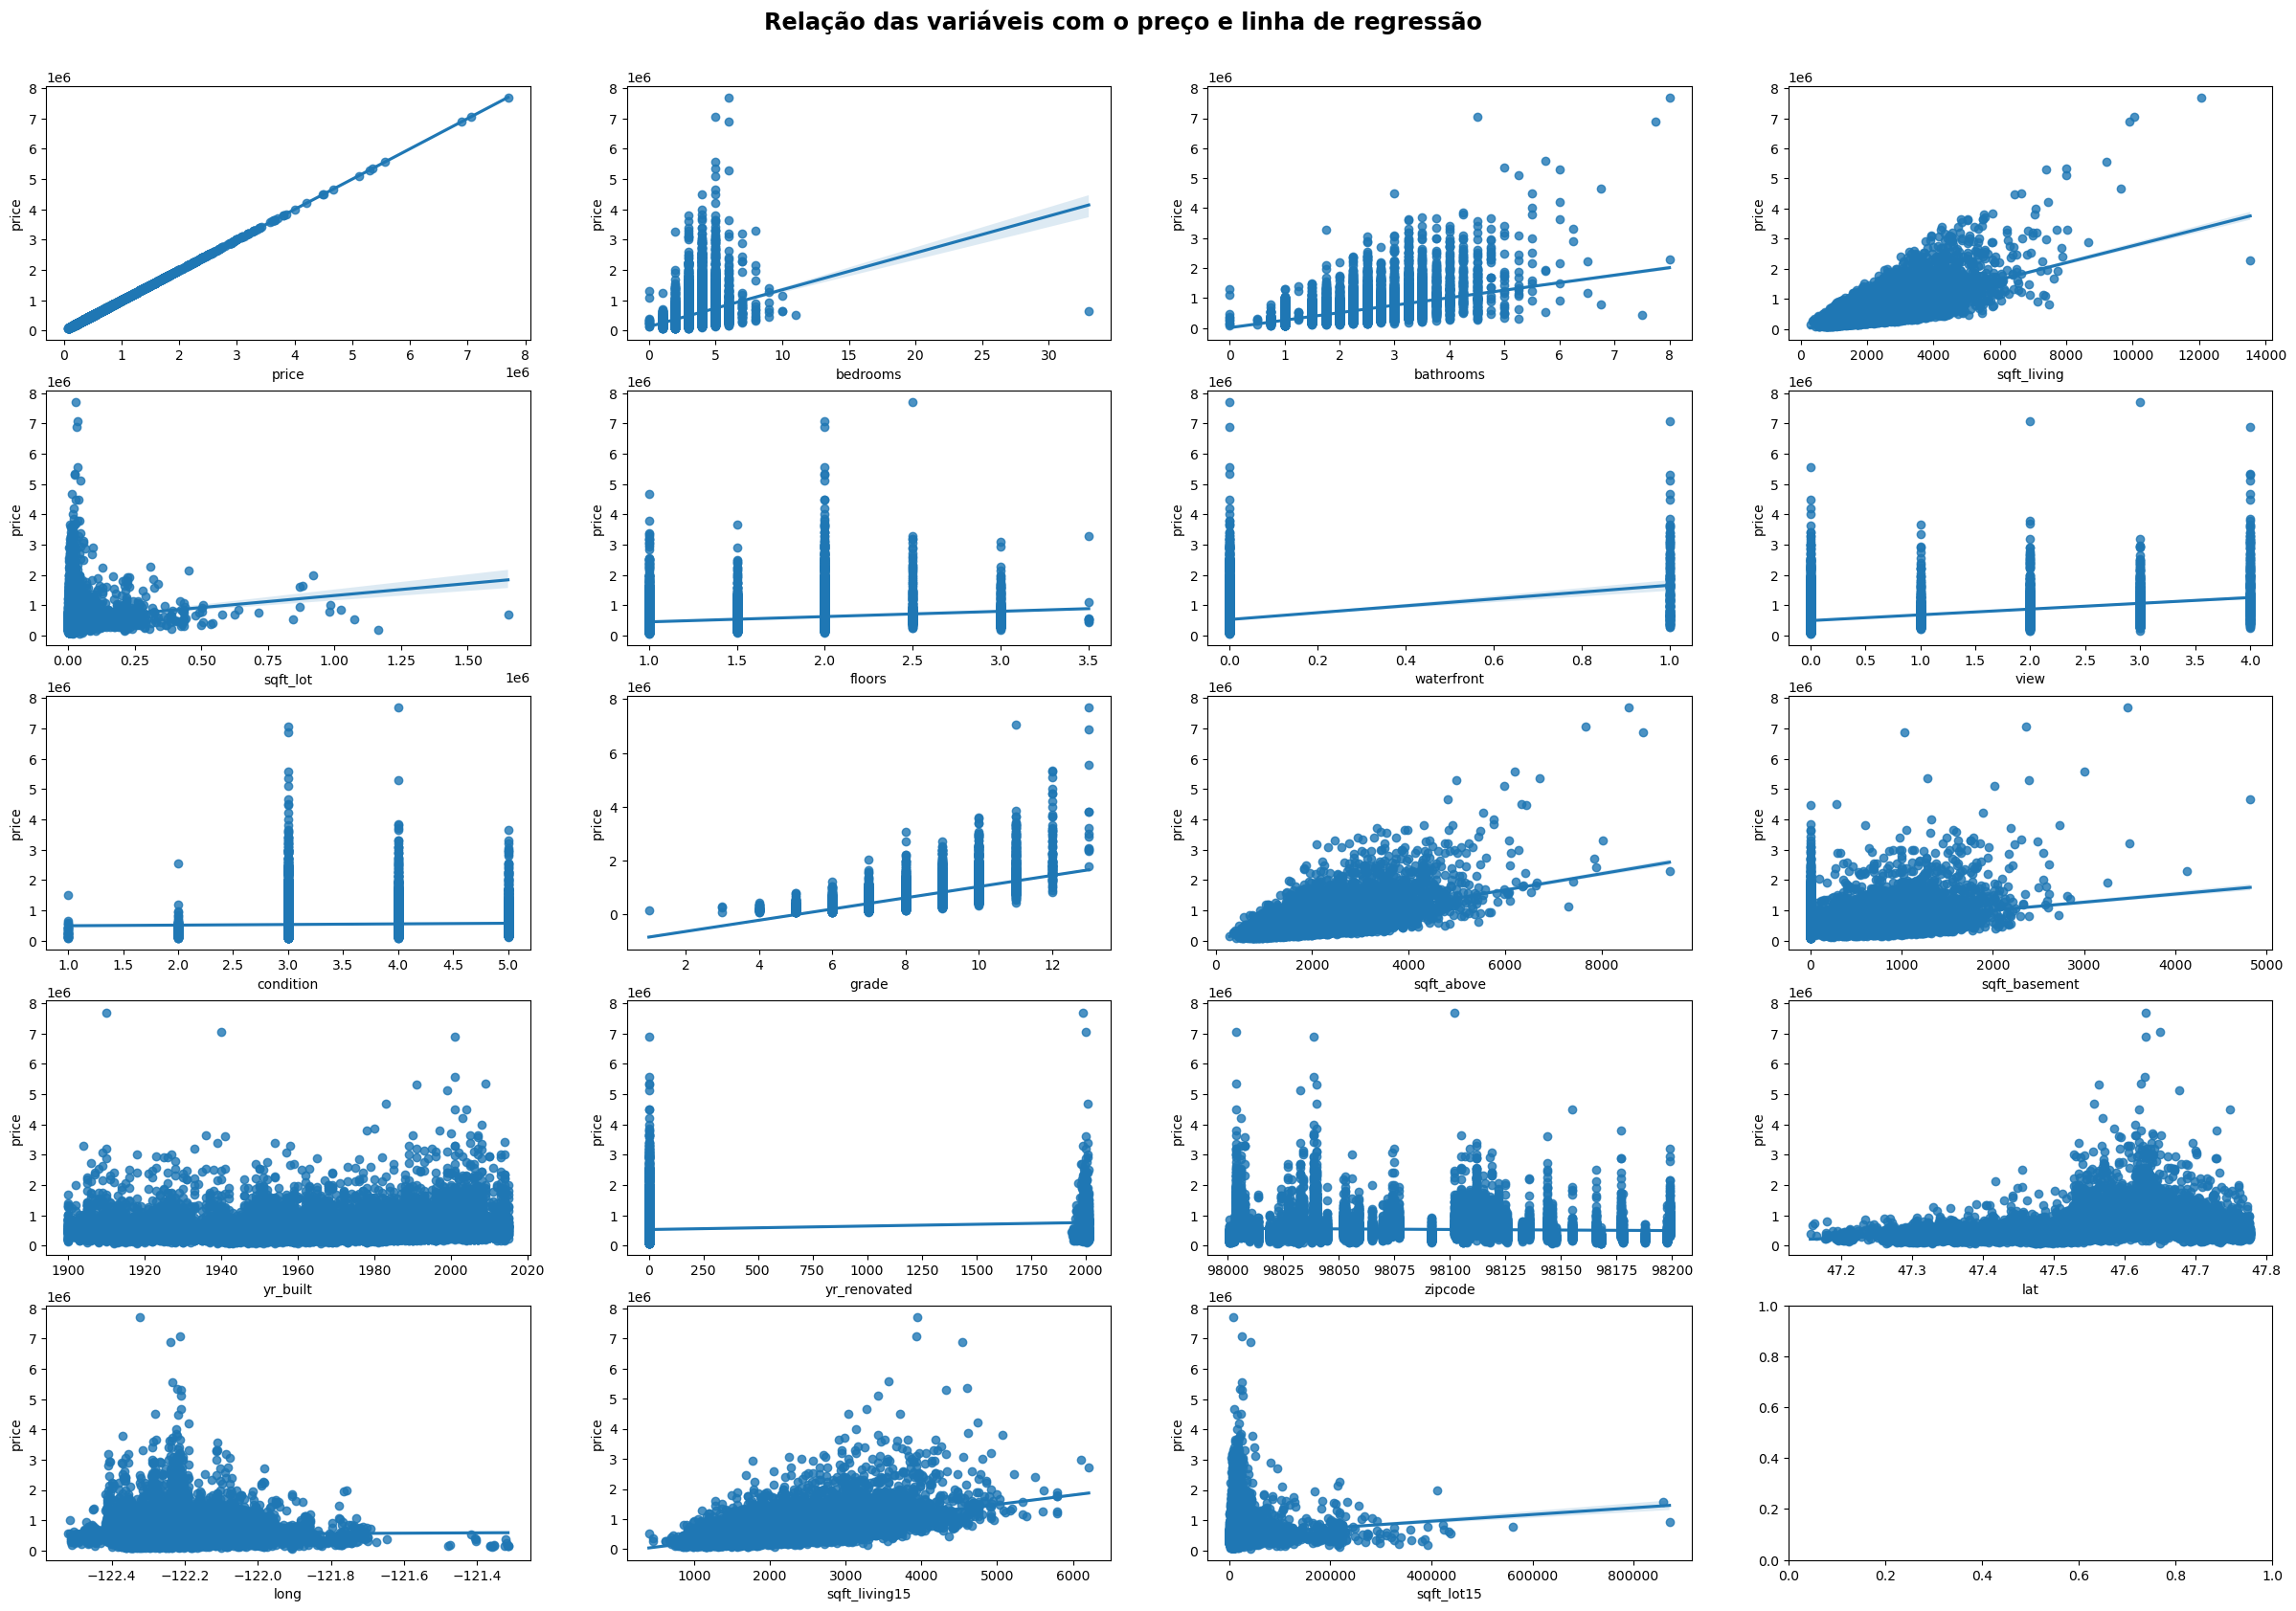

In [19]:
fig, ax = plt.subplots(np.ceil(len(colunas)/4).astype('int8'), 4, figsize=(30,20))
i=0
for col in colunas:
    sns.regplot(sales, x=sales[col], y=sales['price'], ax=ax[int(i/4),i%4])
    i+=1

plt.suptitle('Relação das variáveis com o preço e linha de regressão', size='xx-large', weight='bold',y=0.92)

c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oiac2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='zipcode', ylabel='price'>

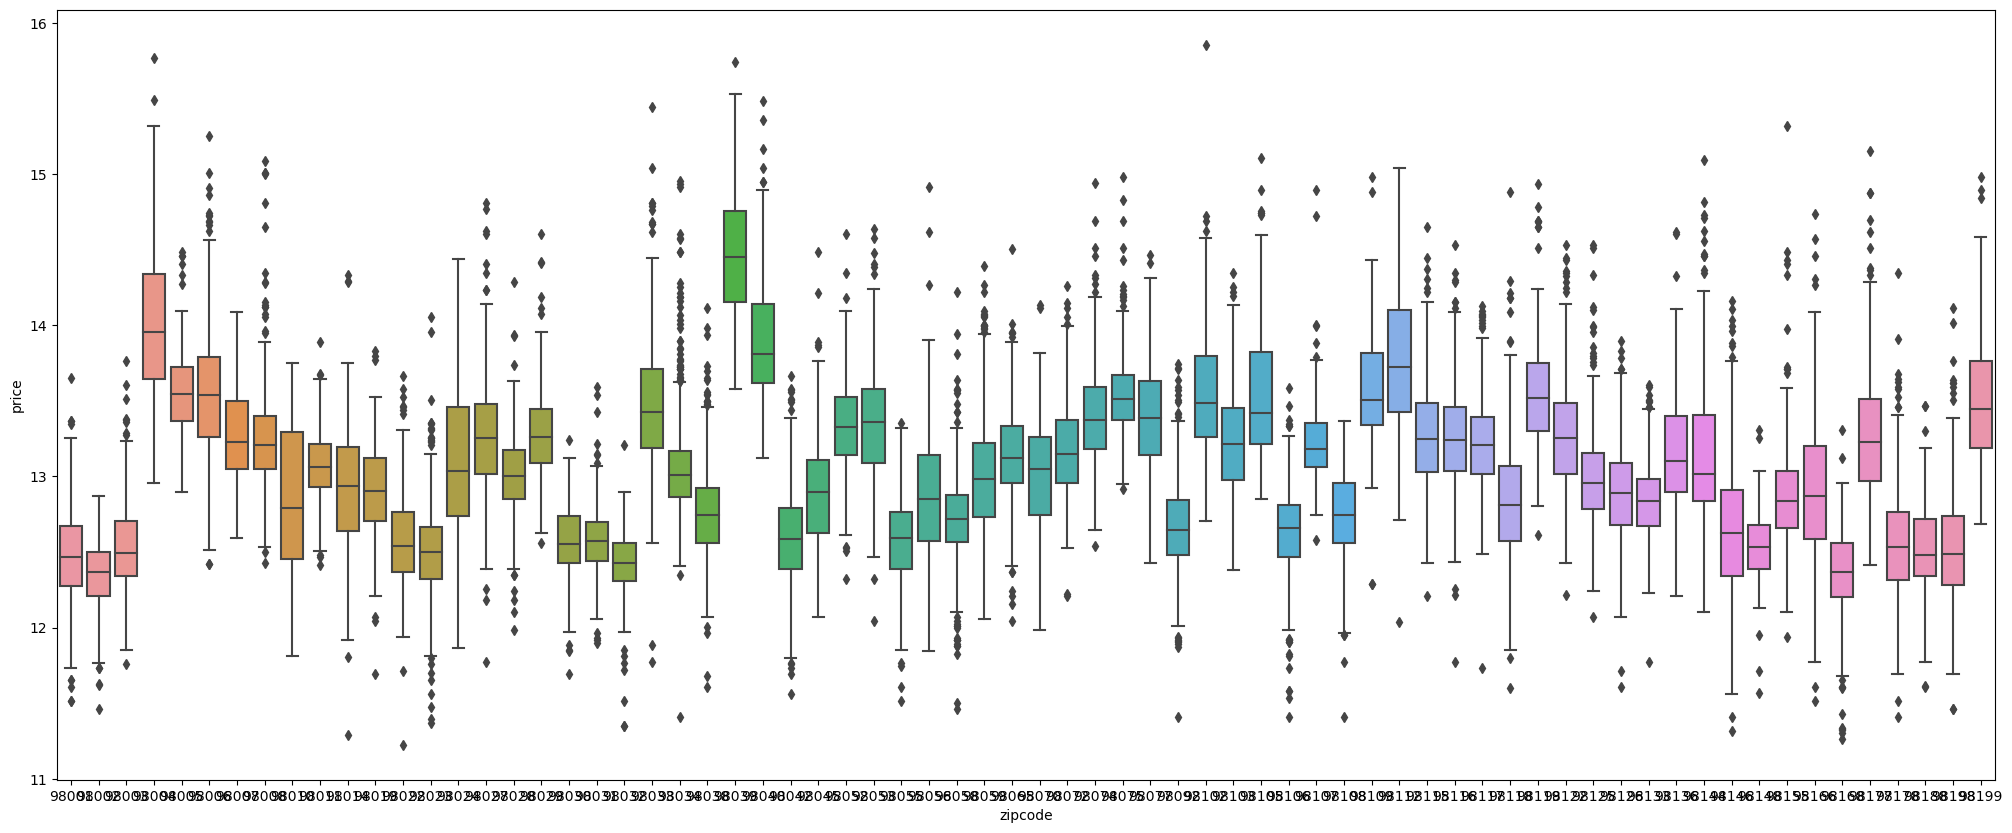

In [20]:
plt.figure(figsize=(25,10))
sns.boxplot(sales, x=sales['zipcode'], y=np.log(sales['price']))

### Atividade 2

Para esta atividade, vocês deverão aplicar as ações de pré-processamento dos dados que julgarem imprescindíveis para o treinamento do algoritmo de aprendizado. Dentre as ações, podemos citar:

1. Limpeza
    * Outliers:
        * Coluna Bedrooms: 33, notavelmente é um outlier, conforme visto no boxplot
        * Verificar colunas:
            * Price
            * Sqft_living comparando com a coluna Sqft_living15
            * Sqft_lot comparando com a coluna Sqft_lot15
    * Remover as colunas:
        * id - feito anteriormente
        * date - feito anteriormente
        * sqft_basement
        * yr_renovated
        * zipcode
        * lat
        * long
1. Transformação
    * Modificação de colunas:
        * Criar coluna:
            * yr_modified para indicar a última modificação na casa com base no ano de construção ou reforma.
        * Modificar coluna:
            * sqft_basement para basement, para indicar se a casa tem porão ou não. O tamanho do porão não vai ser perdido pois a diferença entre sqft_living e sqft_above nos dá a informação da coluna sqft_basement. Redundância.
            * Transformar as colunas lat e long em uma única com a informação de Ponto que pode ser utilizado pelo geopandas.
        * One Hot Encode da coluna zipcode

1. Integração
1. Normalização

In [21]:
sales.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Verificando valores extremos na variável preço, e se estes condizem com a situação do imóvel.

In [22]:
sales.iloc[sales['price'].nlargest(n=10).index]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
3914,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
9254,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
4411,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
1448,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1315,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1164,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
8092,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
2626,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
8638,4489000.0,4,3.00,6430,27517,2.0,0,0,3,12,6430,0,2001,0,98004,47.6208,-122.219,3720,14592


In [23]:
sales.iloc[sales['price'].nsmallest(n=10).index]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1149,75000.0,1,0.00,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
15293,78000.0,2,1.00,780,16344,1.0,0,0,1,5,780,0,1942,0,98168,47.4739,-122.280,1700,10387
465,80000.0,1,0.75,430,5050,1.0,0,0,2,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500
16198,81000.0,2,1.00,730,9975,1.0,0,0,1,5,730,0,1943,0,98168,47.4808,-122.315,860,9000
8274,82000.0,3,1.00,860,10426,1.0,0,0,3,6,860,0,1954,0,98146,47.4987,-122.341,1140,11250
2141,82500.0,2,1.00,520,22334,1.0,0,0,2,5,520,0,1951,0,98168,47.4799,-122.296,1572,10570
18468,83000.0,2,1.00,900,8580,1.0,0,0,3,5,900,0,1918,0,98168,47.4727,-122.270,2060,6533
3767,84000.0,2,1.00,700,20130,1.0,0,0,3,6,700,0,1949,0,98168,47.4752,-122.271,1490,18630
10253,85000.0,2,1.00,830,9000,1.0,0,0,3,6,830,0,1939,0,98032,47.3813,-122.243,1160,7680
16714,85000.0,2,1.00,910,9753,1.0,0,0,3,5,910,0,1947,0,98032,47.3897,-122.236,1160,7405


In [24]:
sales.groupby('bedrooms')['bedrooms'].count()

bedrooms
0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [31]:
sales[sales['bedrooms']==11]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,520000.0,11,3.0,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.556,-122.363,1420,4960


In [26]:
sales[sales['price']==640000].count()

price            52
bedrooms         52
bathrooms        52
sqft_living      52
sqft_lot         52
floors           52
waterfront       52
view             52
condition        52
grade            52
sqft_above       52
sqft_basement    52
yr_built         52
yr_renovated     52
zipcode          52
lat              52
long             52
sqft_living15    52
sqft_lot15       52
dtype: int64

In [27]:
sales[sales['bedrooms']==0].count()

price            13
bedrooms         13
bathrooms        13
sqft_living      13
sqft_lot         13
floors           13
waterfront       13
view             13
condition        13
grade            13
sqft_above       13
sqft_basement    13
yr_built         13
yr_renovated     13
zipcode          13
lat              13
long             13
sqft_living15    13
sqft_lot15       13
dtype: int64

In [28]:
bedroom = sales['bedrooms'].unique()

In [29]:
for bed in bedroom:
    print(sales[sales['bedrooms']==bed]['sqft_living'].mean())

1805.8372353420195
1239.7528985507247
2554.649665794827
3047.5452841973765
884.6130653266332
3284.341911764706
3974.2105263157896
1707.8461538461538
3800.0
3775.0
3000.0
3706.6666666666665
1620.0


In [30]:
for bed in bedroom:
    print(sales[sales['bedrooms']==bed]['price'].mean())

466232.07848127035
401372.681884058
635419.5042138913
786599.8288569644
317642.88442211057
825520.6360294118
951184.6578947369
409503.8461538461
1105076.923076923
893999.8333333334
520000.0
819333.3333333334
640000.0
